### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRFRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform 


### Data Loading

In [2]:
data = pd.read_csv("car_insurance_claim.csv")

In [3]:
data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,...,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,...,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,...,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,...,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,...,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          10302 non-null  int64  
 1   KIDSDRIV    10302 non-null  int64  
 2   BIRTH       10302 non-null  object 
 3   AGE         10295 non-null  float64
 4   HOMEKIDS    10302 non-null  int64  
 5   YOJ         9754 non-null   float64
 6   INCOME      9732 non-null   object 
 7   PARENT1     10302 non-null  object 
 8   HOME_VAL    9727 non-null   object 
 9   MSTATUS     10302 non-null  object 
 10  GENDER      10302 non-null  object 
 11  EDUCATION   10302 non-null  object 
 12  OCCUPATION  9637 non-null   object 
 13  TRAVTIME    10302 non-null  int64  
 14  CAR_USE     10302 non-null  object 
 15  BLUEBOOK    10302 non-null  object 
 16  TIF         10302 non-null  int64  
 17  CAR_TYPE    10302 non-null  object 
 18  RED_CAR     10302 non-null  object 
 19  OLDCLAIM    10302 non-nul

In [5]:
data.columns

Index(['ID', 'KIDSDRIV', 'BIRTH', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME',
       'PARENT1', 'HOME_VAL', 'MSTATUS', 'GENDER', 'EDUCATION', 'OCCUPATION',
       'TRAVTIME', 'CAR_USE', 'BLUEBOOK', 'TIF', 'CAR_TYPE', 'RED_CAR',
       'OLDCLAIM', 'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CLM_AMT', 'CAR_AGE',
       'CLAIM_FLAG', 'URBANICITY'],
      dtype='object')

In [6]:
data.describe()

,ID,KIDSDRIV,AGE,HOMEKIDS,YOJ,TRAVTIME,TIF,CLM_FREQ,MVR_PTS,CAR_AGE,CLAIM_FLAG
count,1.030200e+04,10302.000000,10295.000000,10302.000000,9754.000000,10302.000000,10302.000000,10302.000000,10302.000000,9663.000000,10302.000000
mean,4.956631e+08,0.169288,44.837397,0.720443,10.474062,33.416424,5.329159,0.800718,1.710153,8.298148,0.266550
std,2.864675e+08,0.506512,8.606445,1.116323,4.108943,15.869687,4.110795,1.154079,2.159015,5.714450,0.442177
min,6.317500e+04,0.000000,16.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,-3.000000,0.000000
25%,2.442869e+08,0.000000,39.000000,0.000000,9.000000,22.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,4.970043e+08,0.000000,45.000000,0.000000,11.000000,33.000000,4.000000,0.000000,1.000000,8.000000,0.000000
75%,7.394551e+08,0.000000,51.000000,1.000000,13.000000,44.000000,7.000000,2.000000,3.000000,12.000000,1.000000
max,9.999264e+08,4.000000,81.000000,5.000000,23.000000,142.000000,25.000000,5.000000,13.000000,28.000000,1.000000


### Data Cleaning

In [7]:
# Rename columns
col_names = {
    "KIDSDRIV" : "n_young_drivers",
    "BIRTH" : "date_of_birth",
    "AGE" : "age",
    "HOMEKIDS" : "n_children",
    "YOJ" : "year_of_jobs",
    "INCOME" : "income",
    "PARENT1" : "single_parent",
    "HOME_VAL" : "home_value",
    "MSTATUS" : "married",
    "GENDER" : "gender",
    "EDUCATION" : "highest_education",
    "OCCUPATION" : "occupation",
    "TRAVTIME" : "commute_dist",
    "CAR_USE" : "type_of_use",
    "BLUEBOOK" : "vehicle_values",
    "TIF" : "policy_tenure",
    "CAR_TYPE" : "car_type",
    "RED_CAR" : "red_vehicle",
    "OLDCLAIM" : "5_year_claim_value",
    "CLM_FREQ" : "5_year_num_claim",
    "REVOKED" : "license_revoked",
    "MVR_PTS" : "license_points",
    "CLM_AMT" : "new_claim_value",
    "CAR_AGE" : "vehicle_age",
    "CLAIM_FLAG": "is_claim",
    "URBANICITY" : "address_type",
}

data.rename(columns=col_names, inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  10302 non-null  int64  
 1   n_young_drivers     10302 non-null  int64  
 2   date_of_birth       10302 non-null  object 
 3   age                 10295 non-null  float64
 4   n_children          10302 non-null  int64  
 5   year_of_jobs        9754 non-null   float64
 6   income              9732 non-null   object 
 7   single_parent       10302 non-null  object 
 8   home_value          9727 non-null   object 
 9   married             10302 non-null  object 
 10  gender              10302 non-null  object 
 11  highest_education   10302 non-null  object 
 12  occupation          9637 non-null   object 
 13  commute_dist        10302 non-null  int64  
 14  type_of_use         10302 non-null  object 
 15  vehicle_values      10302 non-null  object 
 16  poli

In [9]:
# Check for duplicate rows 
data.duplicated().sum()


1

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
# data.dropna(axis=0, inplace=True)

In [12]:
currency_col = ['income', 'home_value', 'vehicle_values', '5_year_claim_value', 'new_claim_value']

# Remove $ symbols on those columns
def remove_currency(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype("Int64")
    return data

data = remove_currency(data, currency_col)

In [13]:
# Remove z_ prefix
def remove_prefix(data):
    data = data.replace('[z_]', '', regex=True)
    return data

data = remove_prefix(data)

In [14]:
((data['new_claim_value'] > 0) & (data['is_claim'] == 0)).sum()

0

In [15]:
data.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

In [16]:
data.head()

,n_young_drivers,age,n_children,year_of_jobs,income,single_parent,home_value,married,gender,highest_education,...,car_type,red_vehicle,5_year_claim_value,5_year_num_claim,license_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,...,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,...,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,...,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,...,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,...,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


<Axes: xlabel='new_claim_value', ylabel='Count'>

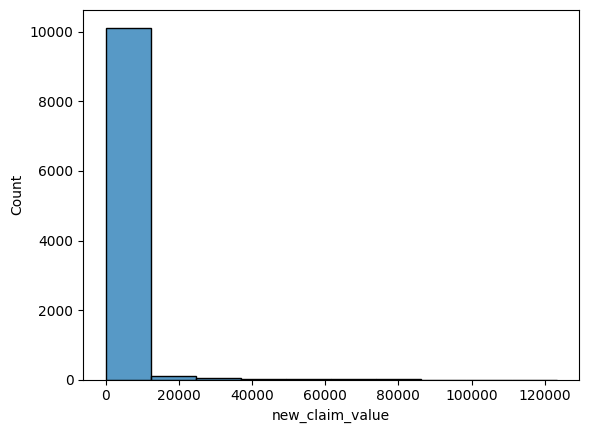

In [17]:
sns.histplot(data['new_claim_value'], bins=10)

In [18]:
# Define the bins
bins = np.arange(0, 50000+1, 5000).astype(float).tolist()
bins.append(np.inf)

# Define bins label
labels = np.arange(1, 12)

# Apply the bins
data['claim_value_cat'] = pd.cut(data['new_claim_value'], bins=bins, labels=labels, include_lowest=True )

<Axes: ylabel='claim_value_cat'>

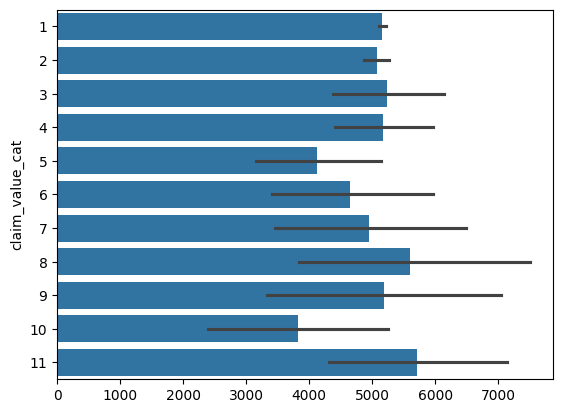

In [19]:
# Show distribution with bar plot
sns.barplot(data['claim_value_cat'])

In [20]:
X = data.copy()
y = data['is_claim']

X.drop(columns=['new_claim_value', 'is_claim'], inplace=True)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['claim_value_cat'])

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10301 entries, 0 to 10301
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   n_young_drivers     10301 non-null  int64   
 1   age                 10294 non-null  float64 
 2   n_children          10301 non-null  int64   
 3   year_of_jobs        9753 non-null   float64 
 4   income              9731 non-null   Int64   
 5   single_parent       10301 non-null  object  
 6   home_value          9726 non-null   Int64   
 7   married             10301 non-null  object  
 8   gender              10301 non-null  object  
 9   highest_education   10301 non-null  object  
 10  occupation          9636 non-null   object  
 11  commute_dist        10301 non-null  int64   
 12  type_of_use         10301 non-null  object  
 13  vehicle_values      10301 non-null  Int64   
 14  policy_tenure       10301 non-null  int64   
 15  car_type            10301 non-null  objec

In [22]:
# Check positive / negative class ratio for y_train and y_test
train_ratio = y_train.sum() / len(y_train)
test_ratio = y_test.sum() / len(y_test)

print("train ratio: ", train_ratio)
print("test_ratio: ", test_ratio)

train ratio:  0.26480582524271845
test_ratio:  0.27365356622998543


In [23]:
# Remove bins from each set
for set in (X_train, X_test):
    set.drop(columns=['claim_value_cat'], inplace=True)

### Exploratory Data Analysis

In [25]:
# Define binary columns
binary_cols = ['single_parent', 'married', 'gender', 'license_revoked']

# Define mapping
mapping = {"Yes": 1,
            "No": 0,
            "yes": 1,
            "no": 0,
            "M": 1,
            "F": 0,}

test_data = X_train.copy()

def binary_encode(data, cols, mappings):
    data = data.copy()
    for col in cols:
        data[col] = data[col].map(mappings).astype('object')
    return data

In [26]:
X_train_eda = binary_encode(test_data, binary_cols, mapping) 
X_train_eda['is_claim'] = y_train
X_train_eda.head()

,n_young_drivers,age,n_children,year_of_jobs,income,single_parent,home_value,married,gender,highest_education,...,policy_tenure,car_type,red_vehicle,5_year_claim_value,5_year_num_claim,license_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,...,10,SUV,no,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,...,4,Sports Car,no,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,...,4,Minivan,no,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,...,1,Minivan,no,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,...,1,Pickup,no,0,0,0,1,5.0,Highly Urban/ Urban,0


In [28]:
# Correlation matrix
corr_matrix = X_train_eda.corr(numeric_only=True).sort_values(by='is_claim', ascending=False)

<Axes: >

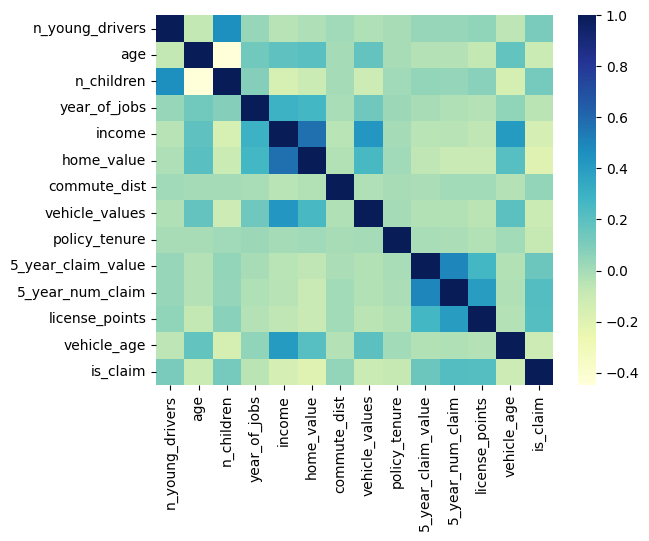

In [29]:
sns.heatmap(X_train_eda.corr(numeric_only=True), cmap='YlGnBu')

In [30]:
corr_no_claim = corr_matrix.drop('is_claim')

<Axes: >

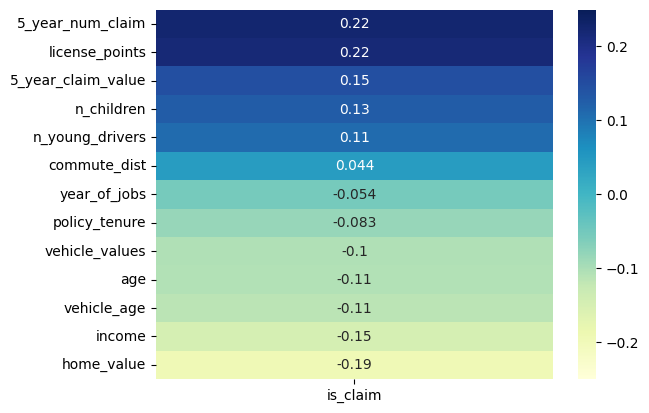

In [31]:
sns.heatmap(corr_no_claim[['is_claim']], cmap="YlGnBu", annot=True, vmax=0.25, vmin=-0.25)

### Data Cleaning

In [32]:
# Dropping features
X_train.drop(columns=['red_vehicle'], inplace=True)

In [33]:
# Handling missing values
X_train.isnull().sum()

n_young_drivers         0
age                     5
n_children              0
year_of_jobs          433
income                474
single_parent           0
home_value            462
married                 0
gender                  0
highest_education       0
occupation            527
commute_dist            0
type_of_use             0
vehicle_values          0
policy_tenure           0
car_type                0
5_year_claim_value      0
5_year_num_claim        0
license_revoked         0
license_points          0
vehicle_age           517
address_type            0
dtype: int64

#### Impute Numerical data

In [34]:
# KNN imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Select numerical columns
numeric_cols_df = X_train.select_dtypes(include=['number'])
numeric_cols = numeric_cols_df.columns.tolist()

# Select categorical columns
cat_cols_df = X_train.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [35]:
# Function to impute values
def numeric_knn_imputers(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

numeric_data_imputed = numeric_knn_imputers(X_train, numeric_cols, knn_imputer)

In [36]:
#  Get numerical cols as a df
numeric_df = X_train[numeric_cols].reset_index(drop=True)

# Select rows with missing values and show heads
missing_df = numeric_df[numeric_df.isna().any(axis=1)]

In [37]:
missing_df.head()

,n_young_drivers,age,n_children,year_of_jobs,income,home_value,commute_dist,vehicle_values,policy_tenure,5_year_claim_value,5_year_num_claim,license_points,vehicle_age
0,0,57.0,0,NaN,33707,0,40,7200,10,0,0,1,1.0
11,0,36.0,2,13.0,19934,<NA>,17,10790,6,7797,2,9,1.0
19,0,59.0,0,11.0,123969,347418,35,31540,1,0,0,1,NaN
25,0,51.0,0,7.0,141546,351285,18,29330,4,1184,2,4,NaN
28,1,51.0,1,8.0,<NA>,253662,5,12430,1,9000,1,0,11.0


In [38]:
# show the same but after imputatio
imputed_df = numeric_data_imputed.loc[missing_df.index, :]

In [39]:
imputed_df.head()

,n_young_drivers,age,n_children,year_of_jobs,income,home_value,commute_dist,vehicle_values,policy_tenure,5_year_claim_value,5_year_num_claim,license_points,vehicle_age
0,0.0,57.0,0.0,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
11,0.0,36.0,2.0,13.0,19934.0,158778.5,17.0,10790.0,6.0,7797.0,2.0,9.0,1.0
19,0.0,59.0,0.0,11.0,123969.0,347418.0,35.0,31540.0,1.0,0.0,0.0,1.0,8.5
25,0.0,51.0,0.0,7.0,141546.0,351285.0,18.0,29330.0,4.0,1184.0,2.0,4.0,7.0
28,1.0,51.0,1.0,8.0,67333.0,253662.0,5.0,12430.0,1.0,9000.0,1.0,0.0,11.0


#### Impute Categorical data

In [40]:
simple_imputer = SimpleImputer(strategy="most_frequent")

def categorical_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

cat_data_imputed = categorical_imputer(X_train, cat_cols, simple_imputer)

#### Rejoin Numerical and Categorical

In [41]:
trained_imputed_df = pd.concat([cat_data_imputed, numeric_data_imputed], axis=1)

In [42]:
trained_imputed_df.head()

,single_parent,married,gender,highest_education,occupation,type_of_use,car_type,license_revoked,address_type,n_young_drivers,...,year_of_jobs,income,home_value,commute_dist,vehicle_values,policy_tenure,5_year_claim_value,5_year_num_claim,license_points,vehicle_age
0,No,No,F,<High School,Blue Collar,Private,SUV,No,Highly Rural/ Rural,0.0,...,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
1,No,Yes,F,<High School,Blue Collar,Private,Sports Car,No,Highly Urban/ Urban,2.0,...,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0
2,Yes,No,M,<High School,Clerical,Private,Minivan,No,Highly Urban/ Urban,0.0,...,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0
3,Yes,No,F,Bachelors,Professional,Private,Minivan,No,Highly Urban/ Urban,0.0,...,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0
4,No,Yes,M,High School,Professional,Commercial,Pickup,No,Highly Urban/ Urban,0.0,...,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0


In [43]:
trained_imputed_df.isna().sum()

single_parent         0
married               0
gender                0
highest_education     0
occupation            0
type_of_use           0
car_type              0
license_revoked       0
address_type          0
n_young_drivers       0
age                   0
n_children            0
year_of_jobs          0
income                0
home_value            0
commute_dist          0
vehicle_values        0
policy_tenure         0
5_year_claim_value    0
5_year_num_claim      0
license_points        0
vehicle_age           0
dtype: int64

#### Categorical Encoding

In [44]:
cat_data_imputed.nunique()

single_parent        2
married              2
gender               2
highest_education    5
occupation           8
type_of_use          2
car_type             6
license_revoked      2
address_type         2
dtype: int64

In [45]:
cat_cols = cat_data_imputed.nunique().index.tolist()

In [46]:
# Ordinal features
ord_cols = ['highest_education']

# Define one hot features
onehot_cols = ['occupation', 'car_type']

# Define categorical features
categorical_cols = [ i for i in cat_cols  if i not in ord_cols and i not in onehot_cols ]

In [47]:
categorical_cols

['single_parent',
 'married',
 'gender',
 'type_of_use',
 'license_revoked',
 'address_type']

In [48]:
# Create encoders
edu_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

ordinal_encoder = OrdinalEncoder(categories=edu_rank)
cat_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [49]:
ord_encoded = ordinal_encoder.fit_transform(cat_data_imputed[ord_cols])
cat_encoded = cat_encoder.fit_transform(cat_data_imputed[categorical_cols])
onehot_encoded = onehot_encoder.fit_transform(cat_data_imputed[onehot_cols])

In [50]:
ord_encoded_df = pd.DataFrame(ord_encoded)
ord_encoded_df.columns = ord_cols

cat_encoded_df = pd.DataFrame(cat_encoded)
cat_encoded_df.columns = categorical_cols

onehot_encoded_df = pd.DataFrame(onehot_encoded)
onehot_encoded_df.columns = onehot_encoder.get_feature_names_out()

all_categorical = pd.concat([ord_encoded_df, cat_encoded_df, onehot_encoded_df], axis=1)
all_categorical.head()

,highest_education,single_parent,married,gender,type_of_use,license_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,...,occupation_Lawyer,occupation_Manager,occupation_Professional,occupation_Student,car_type_Minivan,car_type_Panel Truck,car_type_Pickup,car_type_SUV,car_type_Sports Car,car_type_Van
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Joining to make a clean dataframe

In [51]:
X_train_clean = pd.concat([all_categorical, trained_imputed_df[numeric_cols]], axis=1)
X_train_clean.head()

,highest_education,single_parent,married,gender,type_of_use,license_revoked,address_type,occupation_Blue Collar,occupation_Clerical,occupation_Doctor,...,year_of_jobs,income,home_value,commute_dist,vehicle_values,policy_tenure,5_year_claim_value,5_year_num_claim,license_points,vehicle_age
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0


In [52]:
# Calculate VIF
def calc_vif(df):
    # Add constant
    df_const = add_constant(df)

    # Calc VIF for each feature
    vif_data = pd.DataFrame()
    vif_data['Feature'] = df_const.columns
    vif_data['VIF'] = [variance_inflation_factor(df_const.values, i) for i in range(df_const.shape[1])]

    return vif_data

In [53]:
vif_df = calc_vif(X_train_clean)

c:\Users\Ha Tung Lam\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\Ha Tung Lam\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [54]:
vif_df

,Feature,VIF
0,const,0.000000
1,highest_education,3.022476
2,single_parent,1.858896
3,married,1.966856
4,gender,2.598426
5,type_of_use,2.263201
6,license_revoked,1.282906
7,address_type,1.251420
8,occupation_Blue Collar,inf
9,occupation_Clerical,inf


In [55]:
X_train_clean.drop(['occupation_Blue Collar', 'car_type_Minivan'], axis=1, inplace=True)

vif_df = calc_vif(X_train_clean)
vif_df

,Feature,VIF
0,const,80.124998
1,highest_education,3.022476
2,single_parent,1.858896
3,married,1.966856
4,gender,2.598426
5,type_of_use,2.263201
6,license_revoked,1.282906
7,address_type,1.251420
8,occupation_Clerical,1.849405
9,occupation_Doctor,1.550254


In [56]:
X_train_clean

,highest_education,single_parent,married,gender,type_of_use,license_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,...,year_of_jobs,income,home_value,commute_dist,vehicle_values,policy_tenure,5_year_claim_value,5_year_num_claim,license_points,vehicle_age
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,33707.0,0.0,40.0,7200.0,10.0,0.0,0.0,1.0,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,14.0,17321.0,109835.0,24.0,6530.0,4.0,0.0,0.0,3.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,12.0,54310.0,174139.0,39.0,1500.0,4.0,5419.0,1.0,5.0,6.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,13.0,62886.0,202178.0,18.0,22260.0,1.0,5290.0,1.0,6.0,6.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,8.0,115182.0,312887.0,25.0,5400.0,1.0,0.0,0.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8235,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,14.0,54064.0,201418.0,7.0,12220.0,7.0,0.0,0.0,2.0,7.0
8236,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,10.0,22746.0,192479.0,5.0,26300.0,6.0,0.0,0.0,0.0,6.0
8237,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,38939.0,155006.0,28.0,31970.0,4.0,0.0,0.0,1.0,11.0
8238,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,13.0,26413.0,172043.0,29.0,16200.0,4.0,0.0,0.0,1.0,1.0


### Classification Model Selection 

In [57]:
clf_models = [
    ('Logistic Regression', LogisticRegression(solver='liblinear', max_iter=2000)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Linear SVM', LinearSVC(random_state=42, max_iter=1000, dual='auto')),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42, algorithm='SAMME')),
    ('Gradient Boost', GradientBoostingClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
]

In [58]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

result = {}

for clf_name, clf in clf_models:
    cv_score = cross_val_score(clf, X_train_clean, y_train, cv=kf)
    result[clf_name] = cv_score

cv_score_df = pd.DataFrame(result)

c:\Users\Ha Tung Lam\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Ha Tung Lam\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Ha Tung Lam\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Ha Tung Lam\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
c:\Users\Ha Tung Lam\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning

Text(0.5, 1.0, 'Cross Validation score')

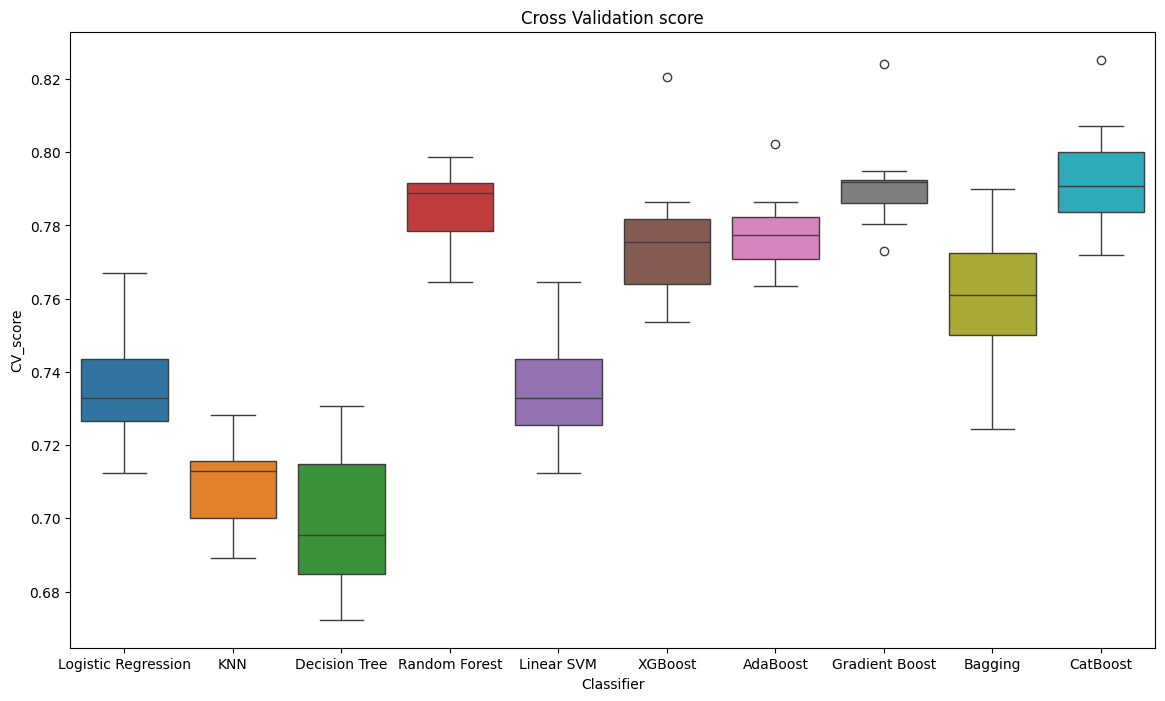

In [59]:
# Plot scores
fig, ax = plt.subplots(figsize=(14,8))
sns.boxplot(cv_score_df)

ax.set_xlabel('Classifier')
ax.set_ylabel('CV_score')
ax.set_title("Cross Validation score")

### Feature Engineering 

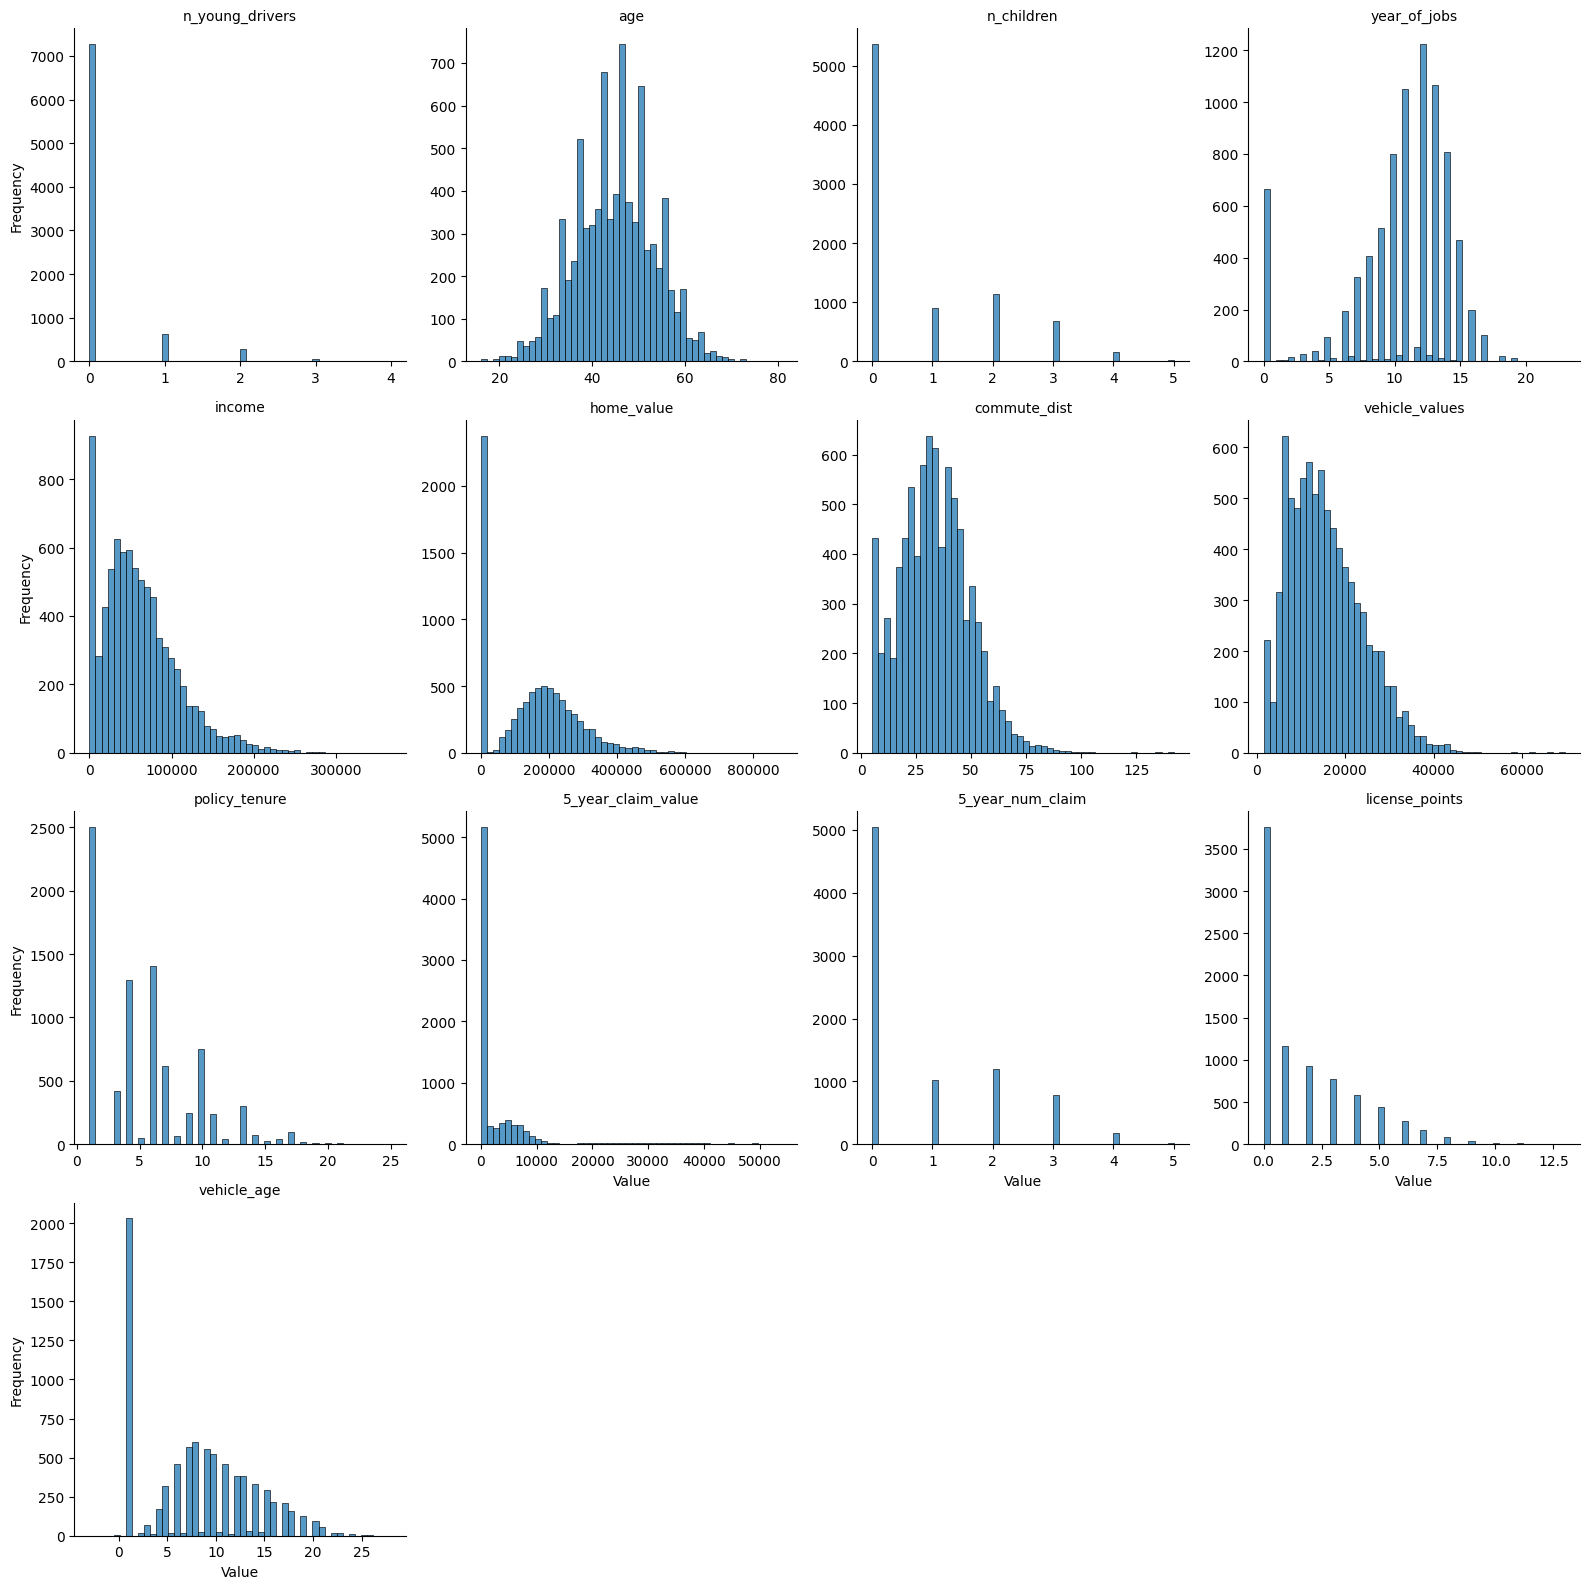

In [67]:
# Plot numerical feature distribution 

# Melt to long format
melt_X_train = X_train_clean[numeric_cols].melt(var_name='Column', value_name="Value")

# Create a facet grid
g = sns.FacetGrid(melt_X_train, col='Column', col_wrap=4, sharex=False, sharey=False, height=4)

# Map histplot to each facet
g.map(sns.histplot, "Value", bins=50)

g.set_axis_labels('Value', 'Frequency')
g.set_titles(col_template='{col_name}')

plt.tight_layout()

In [74]:
# Define a right skewed features
right_skewed = ['income', 'home_value', 'commute_dist', 'vehicle_values', 'policy_tenure', 'license_points']

# Function to squareroot the features
def square_root_features(df, features):
    data = df.copy()
    for feature in features:
        data[feature] = np.sqrt(data[feature])
    return data

In [75]:
X_train_sqrt = square_root_features(X_train_clean, right_skewed)

In [76]:
X_train_sqrt

,highest_education,single_parent,married,gender,type_of_use,license_revoked,address_type,occupation_Clerical,occupation_Doctor,occupation_Home Maker,...,year_of_jobs,income,home_value,commute_dist,vehicle_values,policy_tenure,5_year_claim_value,5_year_num_claim,license_points,vehicle_age
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,183.594662,0.000000,6.324555,84.852814,3.162278,0.0,0.0,1.000000,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,14.0,131.609270,331.413639,4.898979,80.808415,2.000000,0.0,0.0,1.732051,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,12.0,233.045060,417.299653,6.244998,38.729833,2.000000,5419.0,1.0,2.236068,6.0
3,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,13.0,250.770812,449.642080,4.242641,149.197855,1.000000,5290.0,1.0,2.449490,6.0
4,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,8.0,339.384737,559.363031,5.000000,73.484692,1.000000,0.0,0.0,1.000000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8235,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,14.0,232.516666,448.796168,2.645751,110.544109,2.645751,0.0,0.0,1.414214,7.0
8236,2.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,10.0,150.817771,438.724287,2.236068,162.172747,2.449490,0.0,0.0,0.000000,6.0
8237,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,197.329673,393.708014,5.291503,178.801566,2.000000,0.0,0.0,1.000000,11.0
8238,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,13.0,162.520768,414.780665,5.385165,127.279221,2.000000,0.0,0.0,1.000000,1.0
